In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
#data = "https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv"

In [3]:
#!wget $data

In [4]:
housing_data = pd.read_csv("housing.csv")
housing_data

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND


## Preparing the dataset
For this homework, we only want to use a subset of data. This is the same subset we used in homework #2. But in contrast to homework #2, we are going to use all columns of the dataset.

First, keep only the records where ocean_proximity is either '<1H OCEAN' or 'INLAND'

In [5]:
housing_data.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity'],
      dtype='object')

In [6]:
housing_subset = housing_data[(housing_data["ocean_proximity"] == "<1H OCEAN") | (housing_data["ocean_proximity"] == "INLAND")]

## Preparation:

Fill missing values with zeros.

In [7]:
housing_subset.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        157
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [8]:
housing_subset=housing_subset.fillna(0)

In [9]:
housing_subset.isnull().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64

## Apply the log transform to median_house_value.

In [10]:
housing_subset["median_house_value"].mean()

191943.02001657424

In [11]:
housing_subset["median_house_value"]=np.log1p(housing_subset.median_house_value.values)
housing_subset["median_house_value"].mean()

12.010341625731478

In [12]:
housing_subset.median_house_value.value_counts()

13.122367    559
11.831386     92
11.998439     88
11.630717     79
12.141539     64
            ... 
12.652043      1
12.734938      1
13.084248      1
12.325193      1
10.757924      1
Name: median_house_value, Length: 3493, dtype: int64

## Do train/validation/test split with 60%/20%/20% distribution.
Use the train_test_split function and set the random_state parameter to 1.

In [87]:
from sklearn.model_selection import train_test_split

In [96]:
df_full_train, df_test = train_test_split(housing_subset, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [97]:
len(housing_subset), len(df_train) +len(df_val) +len(df_test)

(15687, 15687)

In [98]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [99]:
y_train = df_train.median_house_value.values
y_val = df_val.median_house_value.values
y_test = df_test.median_house_value.values

del df_train['median_house_value']
del df_val['median_house_value']
del df_test['median_house_value']

## Use DictVectorizer(sparse=True) to turn the dataframes into matrices.

In [92]:
from sklearn.feature_extraction import DictVectorizer

In [19]:
df_train.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'ocean_proximity'],
      dtype='object')

In [20]:
columns=['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'ocean_proximity']

In [93]:
dv = DictVectorizer(sparse=True)


train_dict = df_train.to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val.to_dict(orient='records')
X_val = dv.transform(val_dict)

## Question 1
Let's train a decision tree regressor to predict the median_house_value variable.

Train a model with max_depth=1.
Which feature is used for splitting the data?

In [22]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import roc_auc_score
from sklearn.tree import export_text

In [26]:
from sklearn import metrics

In [23]:
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1)

In [27]:
y_pred = dt.predict(X_val)
print ('RMSE:',np.sqrt(metrics.mean_squared_error(y_val,y_pred)))

RMSE: 0.45168599736547216


In [28]:
print(export_text(dt, feature_names=list(dv.get_feature_names_out())))

|--- ocean_proximity=<1H OCEAN <= 0.50
|   |--- value: [11.61]
|--- ocean_proximity=<1H OCEAN >  0.50
|   |--- value: [12.30]



## Question 2
Train a random forest model with these parameters:

n_estimators=10
random_state=1
n_jobs=-1 (optional - to make training faster)
What's the RMSE of this model on validation?

In [29]:
from sklearn.ensemble import RandomForestRegressor

In [30]:
rf = RandomForestRegressor(n_estimators=10,
                            random_state=1,
                           n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

In [31]:
y_pred = rf.predict(X_val)

In [32]:
print ('RMSE:',np.sqrt(metrics.mean_squared_error(y_val,y_pred)))

RMSE: 0.24527740463893766


## Question 3
Now let's experiment with the n_estimators parameter

Try different values of this parameter from 10 to 200 with step 10.
Set random_state to 1.
Evaluate the model on the validation dataset.
After which value of n_estimators does RMSE stop improving? Consider 3 decimal places for retrieving the answer.

In [33]:
scores = []

for n in range(10, 201, 10):
    rf = RandomForestRegressor(n_estimators=n, random_state=1,n_jobs=-1)
    rf.fit(X_train, y_train)

    y_pred = rf.predict(X_val)
    rmse = np.sqrt(metrics.mean_squared_error(y_val,y_pred))
    
    scores.append((n, rmse))

In [ ]:
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'rmse'])
df_scores

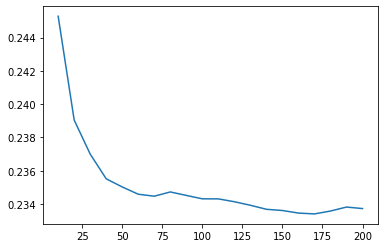

In [35]:
plt.plot(df_scores.n_estimators, df_scores.rmse)

## Question 4
Let's select the best max_depth:

Try different values of max_depth: [10, 15, 20, 25]
For each of these values,
try different values of n_estimators from 10 till 200 (with step 10)
calculate the mean RMSE
Fix the random seed: random_state=1
What's the best max_depth, using the mean RMSE?

In [36]:
scores = []

for d in [10, 15,20,25]:
    for n in range(10, 201, 10):
        rf = RandomForestRegressor(n_estimators=n,
                                    max_depth=d,
                                    random_state=1,
                                  n_jobs=-1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict(X_val)
        rmse = np.sqrt(metrics.mean_squared_error(y_val,y_pred))

        scores.append((d, n, rmse))

In [38]:
df_scores = pd.DataFrame(scores, columns=['max_depth','n_estimators', 'rmse'])
df_scores

,max_depth,n_estimators,rmse
0,10,10,0.250677
1,10,20,0.247672
2,10,30,0.246434
3,10,40,0.245168
4,10,50,0.245557
...,...,...,...
75,25,160,0.233417
76,25,170,0.233433
77,25,180,0.233606
78,25,190,0.233846


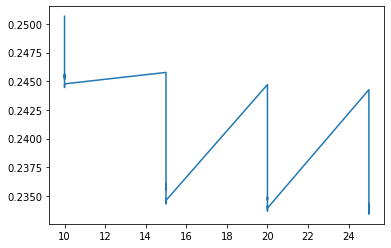

In [39]:
plt.plot(df_scores.max_depth, df_scores.rmse)

## Question 5
We can extract feature importance information from tree-based models.

At each step of the decision tree learning algorithm, it finds the best split. When doing it, we can calculate "gain" - the reduction in impurity before and after the split. This gain is quite useful in understanding what are the important features for tree-based models.

In Scikit-Learn, tree-based models contain this information in the feature_importances_ field.

For this homework question, we'll find the most important feature:

Train the model with these parameters:
n_estimators=10,
max_depth=20,
random_state=1,
n_jobs=-1 (optional)
Get the feature importance information from this model
What's the most important feature (among these 4)?

In [40]:
rf = RandomForestRegressor(n_estimators=10,
                           max_depth=20,
                           random_state=1,
                           n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, n_estimators=10, n_jobs=-1, random_state=1)

In [41]:
importance=rf.feature_importances_

In [42]:
for i,v in enumerate(importance):
    print('Feature: %d0, Score: %.5f' % (i,v))

Feature: 00, Score: 0.01514
Feature: 10, Score: 0.03032
Feature: 20, Score: 0.10201
Feature: 30, Score: 0.08624
Feature: 40, Score: 0.33561
Feature: 50, Score: 0.29247
Feature: 60, Score: 0.07381
Feature: 70, Score: 0.02714
Feature: 80, Score: 0.01585
Feature: 90, Score: 0.02142


In [104]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=10, max_depth=20, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

importance = rf.feature_importances_
feature_names = df_train.columns  

for name, score in zip(feature_names, importance):
    
    print('Feature: {}, Score: {:.5f}'.format(name, score))


Feature: longitude, Score: 0.01514
Feature: latitude, Score: 0.03032
Feature: housing_median_age, Score: 0.10201
Feature: total_rooms, Score: 0.08624
Feature: total_bedrooms, Score: 0.33561
Feature: population, Score: 0.29247
Feature: households, Score: 0.07381
Feature: median_income, Score: 0.02714
Feature: ocean_proximity, Score: 0.01585


In [46]:
from matplotlib import pyplot

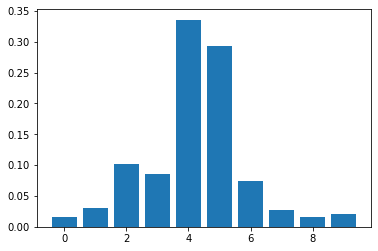

In [47]:
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

## Question 6
Now let's train an XGBoost model! For this question, we'll tune the eta parameter:

Install XGBoost
Create DMatrix for train and validation
Create a watchlist
Train a model with these parameters for 100 rounds:
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

In [49]:
import xgboost as xgb

In [66]:
features = list(dv.get_feature_names_out())
features[5]="ocean_proximity=1H OCEAN"
features


['households',
 'housing_median_age',
 'latitude',
 'longitude',
 'median_income',
 'ocean_proximity=1H OCEAN',
 'ocean_proximity=INLAND',
 'population',
 'total_bedrooms',
 'total_rooms']

In [67]:
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [68]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [80]:
%%capture output

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'nthread': 8,


    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100)

In [81]:
y_pred = model.predict(dval)

In [82]:
print ('RMSE:',np.sqrt(metrics.mean_squared_error(y_val,y_pred)))

RMSE: 0.228623199980106


## Now change eta from 0.3 to 0.1.

Which eta leads to the best RMSE score on the validation dataset?

In [83]:
%%capture output

xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'nthread': 8,


    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100)

In [84]:
y_pred = model.predict(dval)

In [85]:
print ('RMSE:',np.sqrt(metrics.mean_squared_error(y_val,y_pred)))

RMSE: 0.23208927121609343
